Давыдов ПИм-231 лаба 10 ммо

Для выполнения работы Вам понадобится самостоятельно подготовить датасет с картинками! После беглого поиска нашел два подходящих для этого ресурса (можете сами поискать альтернативы):

https://datasetsearch.research.google.com/,

https://ru.freepik.com/search?format=collections&last_filter=selection&last_value=1&query=%D0%B3%D1%80%D1%83%D0%B7%D0%BE%D0%B2%D0%B8%D0%BA&type=photo

https://storage.googleapis.com/openimages/web/visualizer/index.html?type=detection&set=train&c=%2Fm%2F0663v

1) В начале блокнота обязательно опишите процесс подготовки данных с картинками (см. прилагаемый блокнот-пример).

2) Подготовьте данные (файлы с картинками) для задачи классификации с числом классов не менее 5 и не менее 1000 картинок в каждом классе для обучения и 500 для тестирования!

3) Постройте сверточную нейронную сеть и обучите на подготовленных данных.

4) Получите оценку точности на тестовых данных и визуализируйте результаты обучения сети для определения оптимального количества эпох.

5) Выполните аугментацию датасета с обучающим набором картинок и повторите пункты 3-4. Как это сказалось на точности работы сети?

6) Создайте составную нейронную сеть на основе VGG16 и повторите пункты 3-4.

7) Сделайте выводы по проделанной работе. Удачи!

In [ ]:
import os
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers import Dropout
from keras.layers import Conv2D, MaxPooling2D
from keras import utils
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from google.colab import files
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from google.colab.patches import cv2_imshow
import cv2
import random
import shutil
%matplotlib inline

Я нашел датасет снимков лёгких на kaggle:

https://www.kaggle.com/datasets/fatemehmehrparvar/lung-disease?resource=download

Там не 5 классов, а 3, но мне захотелось поработать именно со снимками.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/archive.zip

Archive:  /content/drive/MyDrive/archive.zip
  inflating: Lung X-Ray Image/Lung X-Ray Image/Lung_Opacity/1.jpg  
  inflating: Lung X-Ray Image/Lung X-Ray Image/Lung_Opacity/10.jpg  
  inflating: Lung X-Ray Image/Lung X-Ray Image/Lung_Opacity/100.jpg  
  inflating: Lung X-Ray Image/Lung X-Ray Image/Lung_Opacity/1000.jpg  
  inflating: Lung X-Ray Image/Lung X-Ray Image/Lung_Opacity/1001.jpg  
  inflating: Lung X-Ray Image/Lung X-Ray Image/Lung_Opacity/1002.jpg  
  inflating: Lung X-Ray Image/Lung X-Ray Image/Lung_Opacity/1003.jpg  
  inflating: Lung X-Ray Image/Lung X-Ray Image/Lung_Opacity/1004.jpg  
  inflating: Lung X-Ray Image/Lung X-Ray Image/Lung_Opacity/1005.jpg  
  inflating: Lung X-Ray Image/Lung X-Ray Image/Lung_Opacity/1006.jpg  
  inflating: Lung X-Ray Image/Lung X-Ray Image/Lung_Opacity/1007.jpg  
  inflating: Lung X-Ray Image/Lung X-Ray Image/Lung_Opacity/1008.jpg  
  inflating: Lung X-Ray Image/Lung X-Ray Image/Lung_Opacity/1009.jpg  
  inflating: Lung X-Ray Image/Lung X-R

Функция ниже нужна для того, чтобы работать с файлами из папке также, как в блокноте про кошек и собак.

In [ ]:
def split_data(source, train_dir, validation_dir, split_ratio):
    # Получаем список всех файлов в директории
    files = os.listdir(source)
    # Расчитываем количество файлов для обучающей выборки
    num_train = int(len(files) * split_ratio)
    # Перемешиваем список файлов
    random.shuffle(files)
    # Разделяем файлы на обучающую и валидационную выборки
    train_files = files[:num_train]
    validation_files = files[num_train:]

    # Проверяем, существуют ли директории train_dir и validation_dir, и если нет, то создаем их
    if not os.path.exists(train_dir):
        os.makedirs(train_dir)
    if not os.path.exists(validation_dir):
        os.makedirs(validation_dir)

    # Копируем файлы в соответствующие директории
    for file in train_files:
        shutil.copy(os.path.join(source, file), os.path.join(train_dir, file))
    for file in validation_files:
        shutil.copy(os.path.join(source, file), os.path.join(validation_dir, file))

# Указываем пути к директориям с данными
lung_dir = '/content/Lung X-Ray Image/Lung X-Ray Image/Lung_Opacity'
normal_dir = '/content/Lung X-Ray Image/Lung X-Ray Image/Normal'
pneumo_dir = '/content/Lung X-Ray Image/Lung X-Ray Image/Viral Pneumonia'

# Задаем пути для обучающей и валидационной выборок
base_dir = '/content/lung_data'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Разделение данных на обучающую и валидационную выборки для каждого класса
split_data(lung_dir, os.path.join(train_dir, 'lung_opacity'), os.path.join(validation_dir, 'lung_opacity'), 0.7)
split_data(normal_dir, os.path.join(train_dir, 'normal'), os.path.join(validation_dir, 'normal'), 0.7)
split_data(pneumo_dir, os.path.join(train_dir, 'viral_pneumonia'), os.path.join(validation_dir, 'viral_pneumonia'), 0.7)


In [ ]:
def count_files(directory):
    return len([filename for filename in os.listdir(directory)])

In [ ]:
num_lung_opacity_train = count_files(os.path.join(train_dir, 'lung_opacity'))
num_lung_opacity_val = count_files(os.path.join(validation_dir, 'lung_opacity'))
num_normal_train = count_files(os.path.join(train_dir, 'normal'))
num_normal_val = count_files(os.path.join(validation_dir, 'normal'))
num_viral_pneumonia_train = count_files(os.path.join(train_dir, 'viral_pneumonia'))
num_viral_pneumonia_val = count_files(os.path.join(validation_dir, 'viral_pneumonia'))

print('Lung Opacity в обучающем наборе данных: ', num_lung_opacity_train)
print('Lung Opacity в валидационном наборе данных: ', num_lung_opacity_val)
print('Normal в обучающем наборе данных: ', num_normal_train)
print('Normal в валидационном наборе данных: ', num_normal_val)
print('Viral Pneumonia в обучающем наборе данных: ', num_viral_pneumonia_train)
print('Viral Pneumonia в валидационном наборе данных: ', num_viral_pneumonia_val)

Lung Opacity в обучающем наборе данных:  787
Lung Opacity в валидационном наборе данных:  338
Normal в обучающем наборе данных:  875
Normal в валидационном наборе данных:  375
Viral Pneumonia в обучающем наборе данных:  770
Viral Pneumonia в валидационном наборе данных:  330


Lung Opacity - потемнение на легком

Normal - норма

Viral Pneumonia - пневмония

Данных не очень много, но поэкспериментировать хватит.

In [ ]:
BATCH_SIZE = 50 # размер минибэтча
IMG_SIZE = 150 # размерность, к которой будет приведено входное изображение

In [ ]:
train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)

In [ ]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                          directory=train_dir,
                                                          shuffle=True,
                                                          target_size=(IMG_SIZE,IMG_SIZE),
                                                          class_mode='categorical')

Found 2432 images belonging to 3 classes.


In [ ]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                              directory=validation_dir,
                                                              shuffle=False,
                                                              target_size=(IMG_SIZE,IMG_SIZE),
                                                              class_mode='categorical')

Found 1043 images belonging to 3 classes.


In [ ]:
sample_training_images, _ = next(train_data_gen)

In [ ]:
# данная функция отрисует изображения в сетке размером 1х5
def plotImages(images_arr):
  fig, axes = plt.subplots(1, 5, figsize=(20, 20))
  axes = axes.flatten()
  for img, ax in zip(images_arr, axes):
    ax.imshow(img)
  plt.tight_layout()
  plt.show()

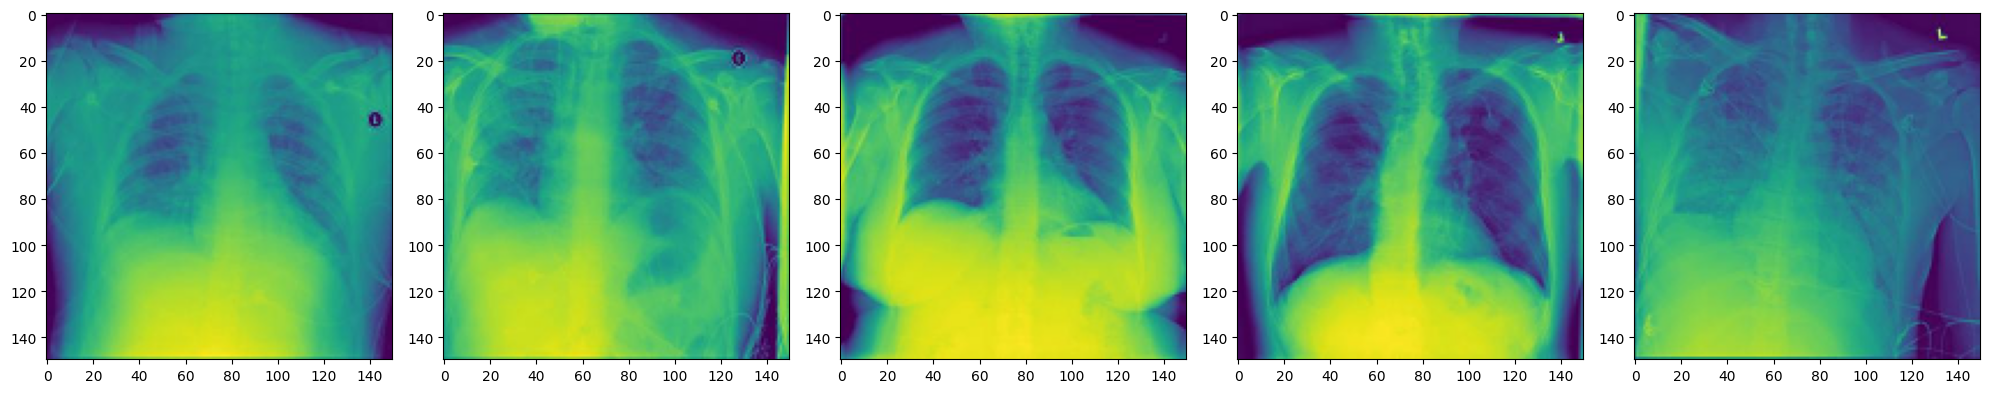

In [ ]:
plotImages(sample_training_images[0:5]) # отрисовываем изображения 0-4

In [ ]:
# Создаем последовательную модель
model = Sequential()
# Первый сверточный слой
model.add(Conv2D(32, (3, 3), input_shape=(IMG_SIZE, IMG_SIZE, 3), activation='relu'))
# Первый слой подвыборки
model.add(MaxPooling2D(pool_size=(2, 2)))
# Слой регуляризации Dropout
model.add(Dropout(0.25))

# Второй сверточный слой
model.add(Conv2D(64, (3, 3), activation='relu'))
# Второй слой подвыборки
model.add(MaxPooling2D(pool_size=(2, 2)))
# Слой регуляризации Dropout
model.add(Dropout(0.25))

# Третий сверточный слой
model.add(Conv2D(128, (3, 3), activation='relu'))
# Третий слой подвыборки
model.add(MaxPooling2D(pool_size=(2, 2)))
# Слой регуляризации Dropout
model.add(Dropout(0.25))

# Четвертый сверточный слой
model.add(Conv2D(128, (3, 3), activation='relu'))
# Еще слой подвыборки
model.add(MaxPooling2D(pool_size=(2, 2)))
# Слой регуляризации Dropout
model.add(Dropout(0.25))

# Слой преобразования данных из 2D представления в плоское
model.add(Flatten())
# Полносвязный слой для классификации
model.add(Dense(512, activation='relu'))
# Слой регуляризации Dropout
model.add(Dropout(0.5))

# Выходной полносвязный слой
model.add(Dense(3, activation='sigmoid'))

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 74, 74, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 36, 36, 64)        0

In [ ]:
EPOCHS = 50
history = model.fit(
    train_data_gen, # указываем тренировочное множество
    #steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
    epochs=EPOCHS,
    validation_data=val_data_gen,  # указываем валидационное множество
    #validation_steps=int(np.ceil(total_val / float(BATCH_SIZE)))
)

Epoch 1/50
49/49 [==============================] - 18s 140ms/step - loss: 0.9565 - accuracy: 0.5333 - val_loss: 0.5849 - val_accuracy: 0.7785
Epoch 2/50
49/49 [==============================] - 5s 101ms/step - loss: 0.5668 - accuracy: 0.7718 - val_loss: 0.5510 - val_accuracy: 0.8073
Epoch 3/50
49/49 [==============================] - 6s 124ms/step - loss: 0.5048 - accuracy: 0.7985 - val_loss: 0.5003 - val_accuracy: 0.8140
Epoch 4/50
49/49 [==============================] - 4s 89ms/step - loss: 0.4730 - accuracy: 0.8059 - val_loss: 0.5279 - val_accuracy: 0.7766
Epoch 5/50
49/49 [==============================] - 4s 91ms/step - loss: 0.4213 - accuracy: 0.8294 - val_loss: 0.4538 - val_accuracy: 0.8198
Epoch 6/50
49/49 [==============================] - 6s 114ms/step - loss: 0.3969 - accuracy: 0.8343 - val_loss: 0.4265 - val_accuracy: 0.8245
Epoch 7/50
49/49 [==============================] - 5s 99ms/step - loss: 0.3854 - accuracy: 0.8475 - val_loss: 0.4165 - val_accuracy: 0.8533
Epoch 8/

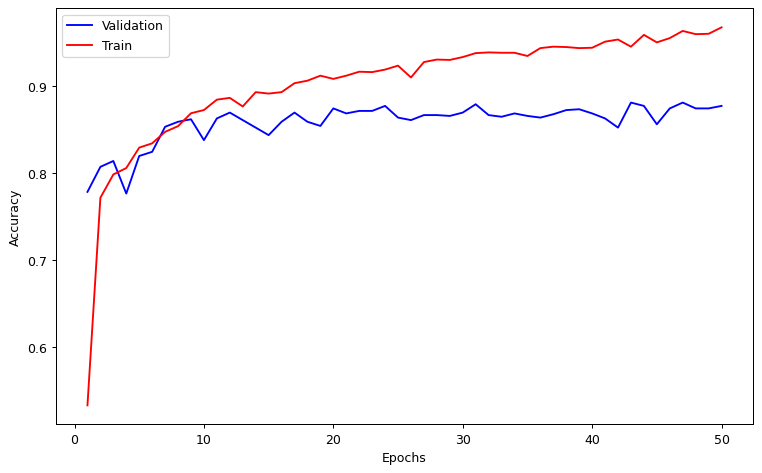

In [ ]:
history_dict = history.history
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(acc_values) + 1)
plt.figure(figsize=(10,6), dpi=90)
plt.plot(epochs, val_acc_values, 'b', label='Validation')
plt.plot(epochs, acc_values, 'r', label='Train')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Далее делаем с аугментацией

In [ ]:
image_gen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_data_gen = image_gen_train.flow_from_directory(batch_size=BATCH_SIZE,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_SIZE, IMG_SIZE),
                                                     class_mode='categorical')

Found 2432 images belonging to 3 classes.


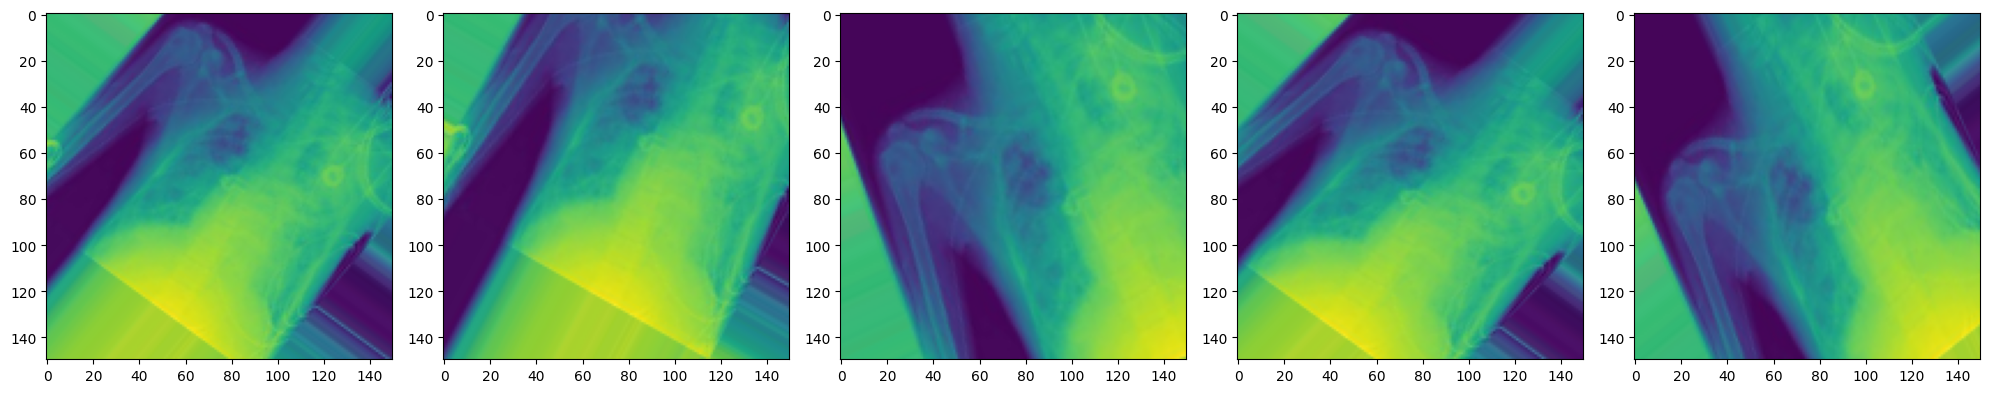

In [ ]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [ ]:
image_gen_val = ImageDataGenerator(rescale=1./255)

val_data_gen = image_gen_val.flow_from_directory(batch_size=BATCH_SIZE,
                                                 directory=validation_dir,
                                                 target_size=(IMG_SIZE, IMG_SIZE),
                                                 class_mode='categorical')

Found 1043 images belonging to 3 classes.


In [ ]:
# Создаем последовательную модель
model = Sequential()
# Первый сверточный слой
model.add(Conv2D(32, (3, 3), input_shape=(IMG_SIZE, IMG_SIZE, 3), activation='relu'))
# Первый слой подвыборки
model.add(MaxPooling2D(pool_size=(2, 2)))
# Слой регуляризации Dropout
model.add(Dropout(0.25))

# Второй сверточный слой
model.add(Conv2D(64, (3, 3), activation='relu'))
# Второй слой подвыборки
model.add(MaxPooling2D(pool_size=(2, 2)))
# Слой регуляризации Dropout
model.add(Dropout(0.25))

# Третий сверточный слой
model.add(Conv2D(128, (3, 3), activation='relu'))
# Третий слой подвыборки
model.add(MaxPooling2D(pool_size=(2, 2)))
# Слой регуляризации Dropout
model.add(Dropout(0.25))

# Четвертый сверточный слой
model.add(Conv2D(128, (3, 3), activation='relu'))
# Еще слой подвыборки
model.add(MaxPooling2D(pool_size=(2, 2)))
# Слой регуляризации Dropout
model.add(Dropout(0.25))

# Слой преобразования данных из 2D представления в плоское
model.add(Flatten())
# Полносвязный слой для классификации
model.add(Dense(512, activation='relu'))
# Слой регуляризации Dropout
model.add(Dropout(0.5))

# Выходной полносвязный слой
model.add(Dense(3, activation='sigmoid'))

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 74, 74, 32)        0         
 g2D)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 74, 74, 32)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 36, 36, 64)       

In [ ]:
EPOCHS = 50
history = model.fit(
    train_data_gen, # указываем тренировочное множество
    #steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
    epochs=EPOCHS,
    validation_data=val_data_gen,  # указываем валидационное множество
    #validation_steps=int(np.ceil(total_val / float(BATCH_SIZE)))
)

Epoch 1/50
49/49 [==============================] - 19s 337ms/step - loss: 1.1486 - accuracy: 0.3569 - val_loss: 0.9884 - val_accuracy: 0.6347
Epoch 2/50
49/49 [==============================] - 19s 397ms/step - loss: 0.9173 - accuracy: 0.5411 - val_loss: 0.7713 - val_accuracy: 0.6989
Epoch 3/50
49/49 [==============================] - 17s 347ms/step - loss: 0.9114 - accuracy: 0.5933 - val_loss: 0.7441 - val_accuracy: 0.7133
Epoch 4/50
49/49 [==============================] - 17s 346ms/step - loss: 0.8413 - accuracy: 0.6164 - val_loss: 0.6941 - val_accuracy: 0.7076
Epoch 5/50
49/49 [==============================] - 17s 348ms/step - loss: 0.7745 - accuracy: 0.6690 - val_loss: 0.6383 - val_accuracy: 0.7555
Epoch 6/50
49/49 [==============================] - 18s 376ms/step - loss: 0.6987 - accuracy: 0.7146 - val_loss: 0.6042 - val_accuracy: 0.7958
Epoch 7/50
49/49 [==============================] - 18s 370ms/step - loss: 0.6734 - accuracy: 0.7319 - val_loss: 0.6111 - val_accuracy: 0.8015

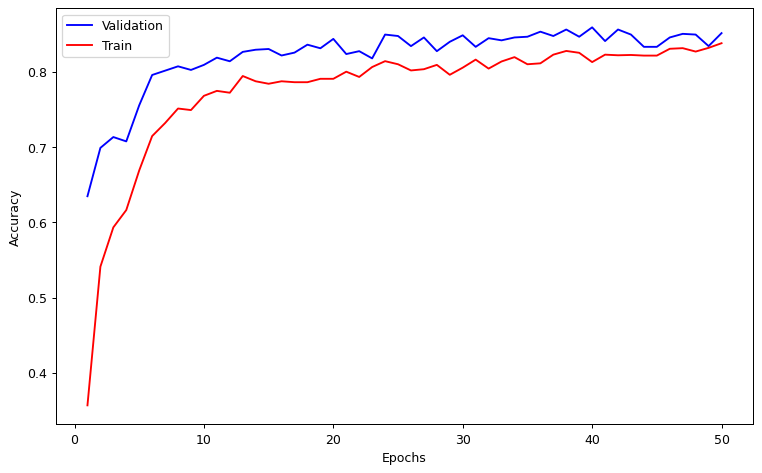

In [ ]:
history_dict = history.history
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(acc_values) + 1)
plt.figure(figsize=(10,6), dpi=90)
plt.plot(epochs, val_acc_values, 'b', label='Validation')
plt.plot(epochs, acc_values, 'r', label='Train')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Аугментация явно улучшила нейросеть

Далее используем VGG

In [ ]:
from tensorflow.keras.applications import VGG16
# адаптируем нейросеть VGG16 с весами, полученными при обучении на imagenet под наши размеры изображения,
# include_top=False - это означает, что последний (классифицирующий) слой мы отключаем
vgg16_net = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
vgg16_net.trainable = False # "Замораживаем" (не позволяем менять) веса предварительно обученной нейронной сети VGG16
vgg16_net.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [ ]:
# Создаем последовательную модель
model = Sequential()

# Добавляем в модель сеть VGG16 вместо групп сверточных слоев
model.add(vgg16_net)

# Полносвязная часть нейронной сети для классификации
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(3, activation='sigmoid'))

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 8192)              0         
                                                                 
 dense_4 (Dense)             (None, 512)               4194816   
                                                                 
 dropout_10 (Dropout)        (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 18911043 (72.14 MB)
Trainable params: 4196355 (16.01 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [ ]:
EPOCHS = 25
history = model.fit(
    train_data_gen, # указываем тренировочное множество
    #steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
    epochs=EPOCHS,
    validation_data=val_data_gen,  # указываем валидационное множество
    #validation_steps=int(np.ceil(total_val / float(BATCH_SIZE)))
)

Epoch 1/25
49/49 [==============================] - 39s 649ms/step - loss: 1.1129 - accuracy: 0.6340 - val_loss: 0.4942 - val_accuracy: 0.8332
Epoch 2/25
49/49 [==============================] - 19s 394ms/step - loss: 0.5240 - accuracy: 0.7993 - val_loss: 0.4532 - val_accuracy: 0.8351
Epoch 3/25
49/49 [==============================] - 22s 448ms/step - loss: 0.4807 - accuracy: 0.8109 - val_loss: 0.3952 - val_accuracy: 0.8437
Epoch 4/25
49/49 [==============================] - 22s 459ms/step - loss: 0.4491 - accuracy: 0.8224 - val_loss: 0.3770 - val_accuracy: 0.8562
Epoch 5/25
49/49 [==============================] - 21s 434ms/step - loss: 0.4446 - accuracy: 0.8232 - val_loss: 0.3522 - val_accuracy: 0.8658
Epoch 6/25
49/49 [==============================] - 20s 411ms/step - loss: 0.4162 - accuracy: 0.8285 - val_loss: 0.3569 - val_accuracy: 0.8552
Epoch 7/25
49/49 [==============================] - 21s 424ms/step - loss: 0.4112 - accuracy: 0.8306 - val_loss: 0.3791 - val_accuracy: 0.8485

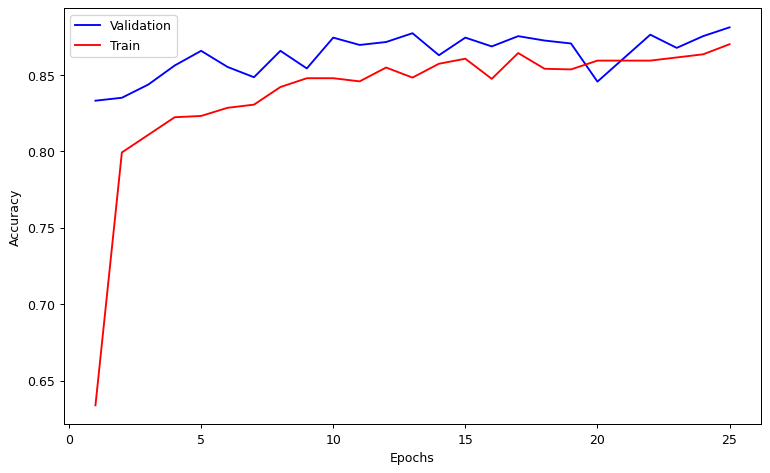

In [ ]:
history_dict = history.history
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(acc_values) + 1)
plt.figure(figsize=(10,6), dpi=90)
plt.plot(epochs, val_acc_values, 'b', label='Validation')
plt.plot(epochs, acc_values, 'r', label='Train')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()